In [166]:
# importing...
from locale import normalize
from statistics import mean
# from turtle import color
import pandas as pd
import json
import os
import warnings
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import seaborn as sns
from scipy import stats
from pingouin import multivariate_normality
from tabulate import tabulate

In [176]:
# Helpers for statistical analysis
def single_variable_normality_test(test_array):
    k, p = stats.normaltest(test_array)
    # threshold = 1e-2
    threshold = 0.05
    if p < threshold:
        # print("Null hypothesis Rejected")
        # Non-normal
        return False
    else:
        # print("Null hypothesis Accepted")
        # Normal
        return True

def anova_test(samples):
    """
    Anova test
    """
    fvalue, pvalue = stats.f_oneway(*samples)
    threshold = 0.05
    if pvalue < threshold:
        # print("Null hypothesis rejected, there are differences among groups")
        return fvalue, pvalue, True
    else:
        return fvalue, pvalue, False

def kw_test(samples, bon_correction=False):
    """
    Kruskal-Wallis test for non-parametric group
    """
    kw, p = stats.kruskal(*samples)
    threshold = 0.05
    if bon_correction:
        correction = len(samples)*(len(samples) - 1)/2
        threshold = threshold/correction
    if p < threshold:
        # print("Rejecting Hypothesis, differences exists")
        return kw, p, True
    else:
        return kw, p, False

def post_hoc_mannwhiteu_test(data1, data2, bonferroni=False):
    u1, p = stats.mannwhitneyu(data1, data2, method="asymptotic")
    threshold = 0.05
    if p < threshold:
        n = True
    else:
        n = False
    # print(u1)
    # print(p)
    # print(n)
    less = "undefined"
    if n:
        # Determine if it is less or more
        _u1, _p = stats.mannwhitneyu(data1, data2, alternative="less", method="asymptotic")
        if _p < threshold:
            less = "smaller"
        else:
            _u1, _p = stats.mannwhitneyu(data2, data1, alternative="less", method="asymptotic")
            if _p < threshold:
                less = "bigger"
    return u1, p, n, less


In [258]:
INPUT_DIR = os.path.join(os.getcwd(), "output")
INPUT_DATA = os.path.join(INPUT_DIR, "children_exploration_results.csv")

# Processing data, Treatment Group/Control Group, (Pre/Post, Intervention)
data = pd.read_csv(INPUT_DATA)
session_num = []
study_group = []
pre_post_intervention = []

# Column Manipulation
for index, row in data.iterrows():
    session_num.append(int(row['session_id'].split('_')[0]))
    study_code = row['study_code']

    if 'treatment' in study_code:
        study_group.append('treatment')
    elif 'control' in study_code:
        study_group.append('control')
    else:
        warnings.warn("study code is neither treatment nor control: " + study_code)
    
    if '-' in study_code:
        pre_post = study_code.split('-')[-1]
        pre_post_intervention.append(pre_post)
    else:
        pre_post_intervention.append("intervention")
data['session number'] = session_num
data['group'] = study_group
data['interaction'] = pre_post_intervention
# print(data.head(5))

## Data Analysis Catalog

### 1. Pre-Intervention and Post-Intervention Sessions Analysis

### 2. Behaviroal Change in Intervention Sessions

### 3. Pre-Intervention Session with First Two Intervention Sessions

### 4. Exploration Correlation with Children's Prior Exploration

### 5. Exploration Correlation with Children's Prior Knowledge

### Part 1: Pre-Intervention and Post-Intervention Sessions Analaysis

In [259]:
def get_normalized_dataframe(data, plotting_value):
    columns_in_question = ['session number', 'child_id', 'interaction', plotting_value]
    # Normalization
    normalized = {
        'child_id': [],
        'session number': [],
        'normalized_by_child': [],
        'original_vals': [],
        'group': []
    }
    for group_condition in ['treatment', 'control']:
        group_data = data[data['group'] == group_condition][columns_in_question]
        # Plot 1: Plotting trend
        child_in_group = list(set(group_data['child_id'].values))
        child_in_group.sort()
        print("%d Children In %s"%(len(child_in_group), group_condition))
        for child in child_in_group:
            # legend.append(child)
            child_data = group_data[group_data['child_id'] == child].copy()
            child_data = child_data.sort_values('session number')
            child_vals = list(child_data[plotting_value])
            normalized_vals = list(preprocessing.normalize([child_vals])[0])
            normalized['child_id'] += list(child_data['child_id'].values)
            normalized['session number'] += list(child_data['session number'].values)
            normalized['normalized_by_child'] += list(normalized_vals)
            normalized['original_vals'] += list(child_vals)
            normalized['group'] += len(child_data['child_id'].values) * [group_condition]

    normalized_dataframe = pd.DataFrame(normalized)
    return normalized_dataframe
    

13 Children In treatment
16 Children In control
  child_id  session number  normalized_by_child  original_vals      group
0     c301               1             0.025726              1  treatment
1     c301               2             0.154354              6  treatment
2     c301               3             0.951852             37  treatment
3     c301               4             0.051451              2  treatment
4     c301               5             0.154354              6  treatment

 c325
   child_id  session number  normalized_by_child  original_vals      group
31     c325               1             0.580259             10  treatment
38     c325               8             0.406181              7  treatment
[10  7]

 c318
   child_id  session number  normalized_by_child  original_vals      group
23     c318               1             0.299918             23  treatment
30     c318               8             0.091279              7  treatment
[23  7]

 c326
   child_id  session 

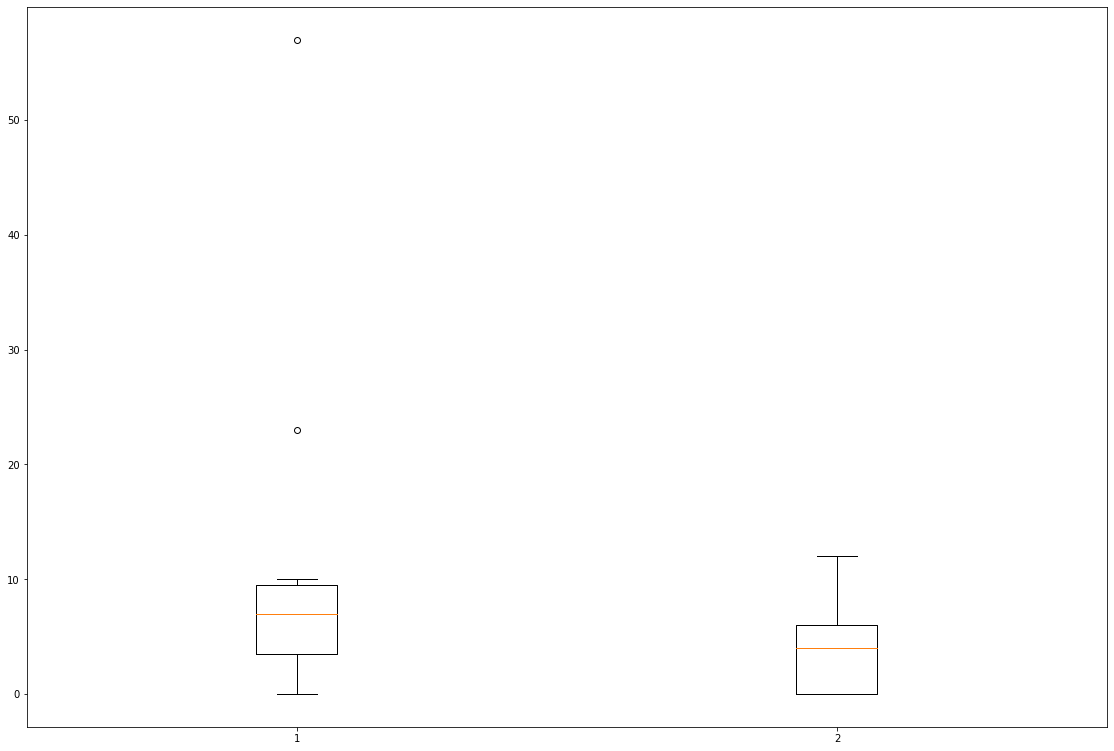


 c309
    child_id  session number  normalized_by_child  original_vals    group
108     c309               1             0.592157              9  control
115     c309               8             0.263181              4  control
[9 4]

 c323
    child_id  session number  normalized_by_child  original_vals    group
132     c323               1             0.707107              1  control
139     c323               8             0.707107              1  control
[1 1]

 c349
    child_id  session number  normalized_by_child  original_vals    group
156     c349               1             0.131876              2  control
163     c349               8             0.065938              1  control
[2 1]

 c370
    child_id  session number  normalized_by_child  original_vals    group
209     c370               1             0.066778              2  control
216     c370               8             0.100167              3  control
[2 3]

 c361
    child_id  session number  normalized_by_child  or

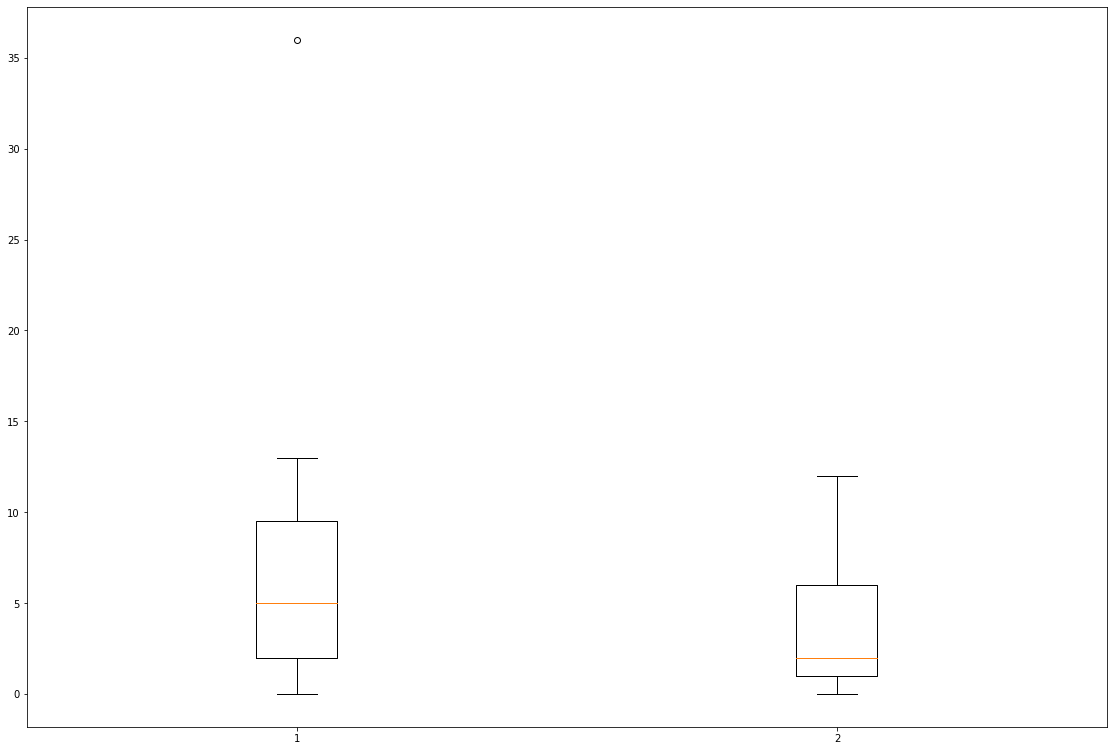

In [260]:
plotting_value = 'total_avg'
plotting_value = 'total_sum'
# plotting_value = 'decoding_sum'
# plotting_value = 'explanation_sum'
# plotting_value = 'decoding_explanation_sum'
feature_selection = 'original_vals'

normalized_df = get_normalized_dataframe(data, plotting_value)
print(normalized_df.head(5))
# 1. Plot box plots
for group_condition in ['treatment', 'control']:
    group_child_data = []
    normalized_group_data = normalized_df[normalized_df['group'] == group_condition]
    for child in list(set(normalized_group_data['child_id'].values)):
        # if child in ['c304']:
        #     continue
        # Get Child's sessions
        child_data = normalized_group_data[normalized_group_data['child_id'] == child]
        child_data = child_data[child_data['session number'].isin([1, 8])]
        if len(child_data) < 2:
            continue
        child_data.sort_values('session number')
        print("\n", child)
        print(child_data)
        print(child_data[feature_selection].values)
        group_child_data.append(list(child_data[feature_selection].values))

    print(group_child_data)
    child_array = np.array(group_child_data)
    # plt_data = np.transpose(child_array)
    plt_data = child_array
    print(plt_data)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_axes([0, 0, 1, 1])
    boxplt = ax.boxplot(plt_data)
    plt.show()

[[0.5802588531856595, 0.4061811972299616, 0.46420708254852755, 0.29012942659282975, 0.17407765595569785, 0.058025885318565944, 0.0, 0.4061811972299616], [0.29991780317012096, 0.8215139825964183, 0.36511732559840815, 0.22167837625617637, 0.1564788538278892, 0.0782394269139446, 0.1173591403709169, 0.09127933139960204], [0.33927557187198837, 0.5089133578079826, 0.4240944648399855, 0.4240944648399855, 0.33927557187198837, 0.08481889296799709, 0.16963778593599418, 0.33927557187198837], [0.02572573358779194, 0.15435440152675164, 0.9518521427483018, 0.05145146717558388, 0.15435440152675164, 0.05145146717558388, 0.15435440152675164, 0.1286286679389597], [0.2565414748854077, 0.21378456240450638, 0.8551382496180255, 0.21378456240450638, 0.2565414748854077, 0.12827073744270384, 0.1710276499236051, 0.0], [0.3038948705590345, 0.49382916465843113, 0.4558423058385518, 0.34188172937891387, 0.4178554470186725, 0.26590801173915524, 0.3038948705590345, 0.037986858819879316], [0.13767902008851549, 0.39336

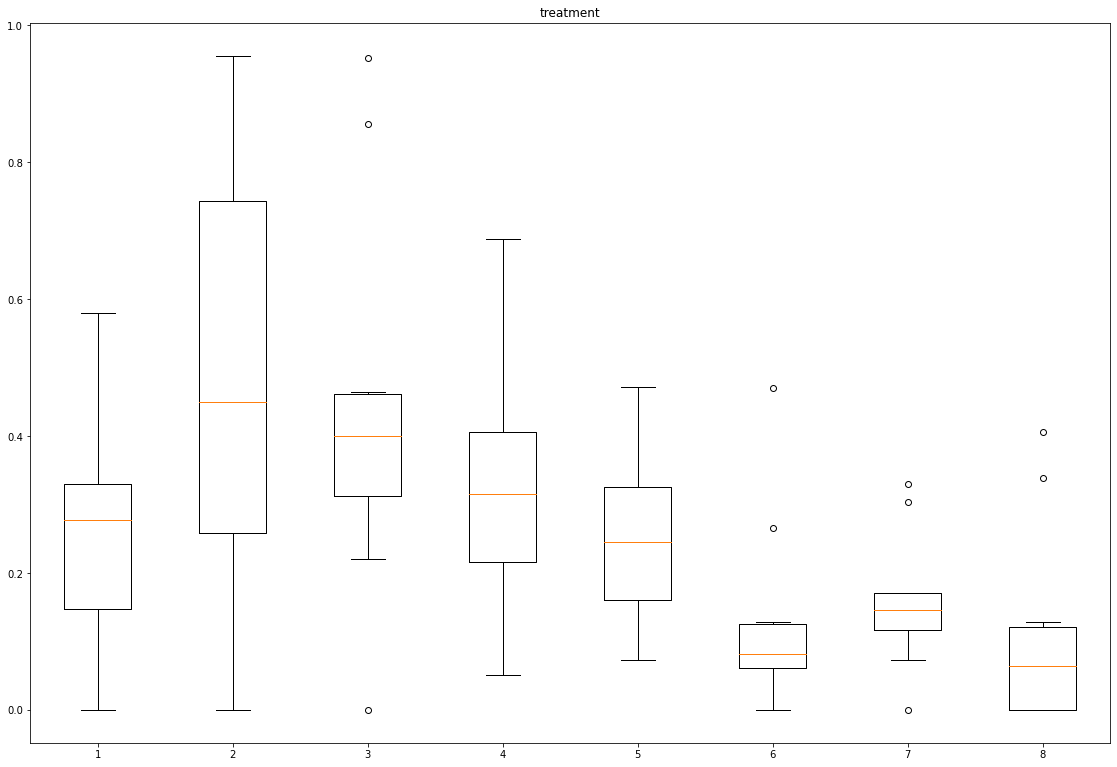

[[0.592156525463792, 0.592156525463792, 0.39477101697586137, 0.1315903389919538, 0.1315903389919538, 0.19738550848793068, 0.0, 0.2631806779839076], [0.7071067811865475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7071067811865475], [0.1318760946791574, 0.659380473395787, 0.1318760946791574, 0.0, 0.7253185207353657, 0.0, 0.0, 0.0659380473395787], [0.06677805632941779, 0.23372319715296225, 0.4674463943059245, 0.30050125348238005, 0.7011695914588867, 0.30050125348238005, 0.20033416898825335, 0.10016708449412667], [0.4969418673368094, 0.4969418673368094, 0.22086305214969307, 0.05521576303742327, 0.44172610429938614, 0.4969418673368094, 0.11043152607484653, 0.0], [0.3254722774520597, 0.7811334658849433, 0.19528336647123581, 0.13018891098082389, 0.39056673294247163, 0.06509445549041194, 0.26037782196164777, 0.06509445549041194], [0.59991668402376, 0.79988891203168, 0.016664352333993333, 0.0, 0.0, 0.0, 0.0, 0.0], [0.2446433609661989, 0.0, 0.10193473373591622, 0.040773893494366484, 0.20386946747183243, 0.

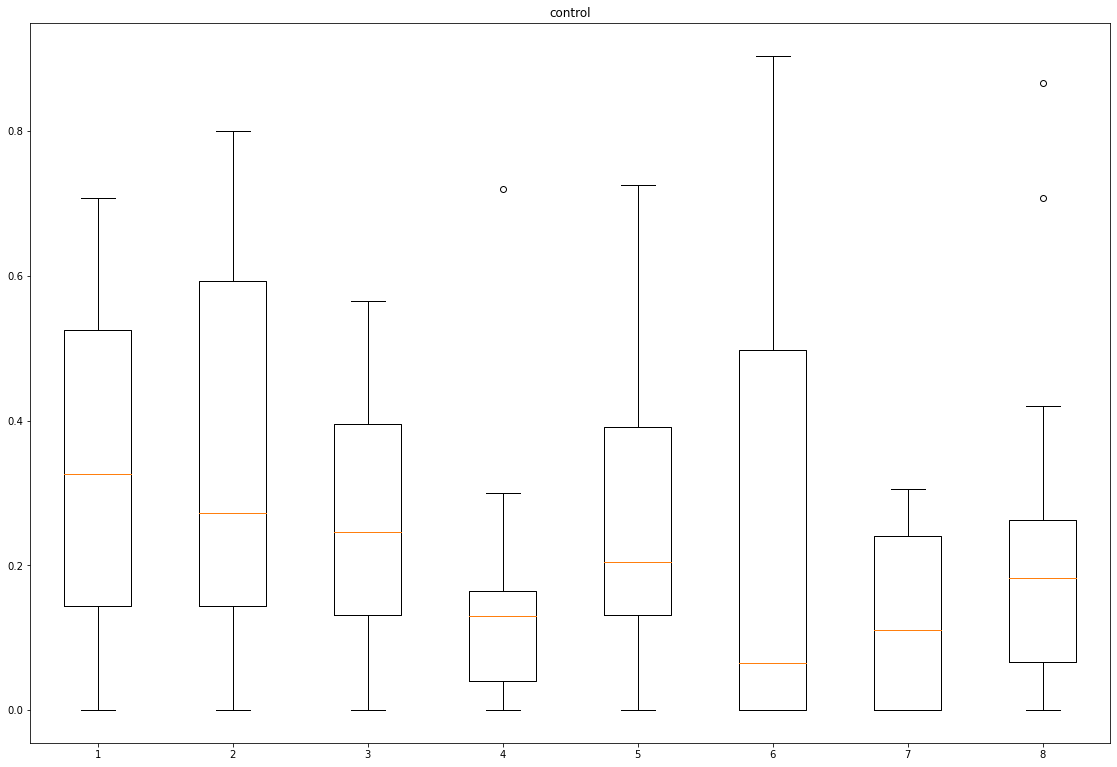

In [271]:
# 2.Plot box for all sessions
from matplotlib.pyplot import title


for group_condition in ['treatment', 'control']:
    group_child_data = []
    normalized_group_data = normalized_df[normalized_df['group'] == group_condition]
    for child in list(set(normalized_group_data['child_id'].values)):
        # if child in ['c304']:
        #     continue
        # Get Child's sessions
        child_data = normalized_group_data[normalized_group_data['child_id'] == child]
        child_data = child_data[child_data['session number'].between(1, 9)]
        if len(child_data) < 8:
            continue
        child_data.sort_values('session number')
        # print("\n", child)
        # print(child_data)
        # print(child_data[feature_selection].values)
        group_child_data.append(list(child_data[feature_selection].values))

    print(group_child_data)
    child_array = np.array(group_child_data)
    # plt_data = np.transpose(child_array)
    plt_data = child_array
    print(plt_data)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_title(group_condition)
    boxplt = ax.boxplot(plt_data)
    plt.show()

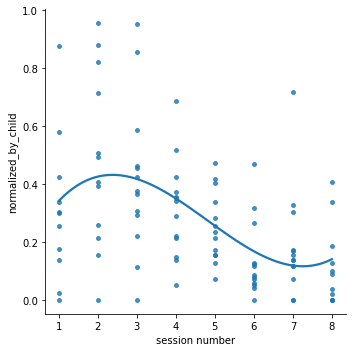

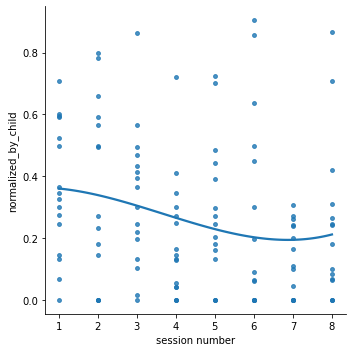

In [305]:

feature_selection = 'normalized_by_child'
for group_condition in ['treatment', 'control']:
    group_child_data = []
    normalized_group_data = normalized_df[normalized_df['group'] == group_condition]
    # sns.lmplot(x="session number", y=feature_selection, data=normalized_group_data, x_estimator=np.mean)
    sns.lmplot(x="session number", y=feature_selection, data=normalized_group_data,
           order=3, ci=None, scatter_kws={"s": 15})

### Part 2: Behavioral Change

13 Children In treatment
16 Children In control
  child_id  session number  normalized_by_child  original_vals      group
0     c301               1             0.025726              1  treatment
1     c301               2             0.154354              6  treatment
2     c301               3             0.951852             37  treatment
3     c301               4             0.051451              2  treatment
4     c301               5             0.154354              6  treatment


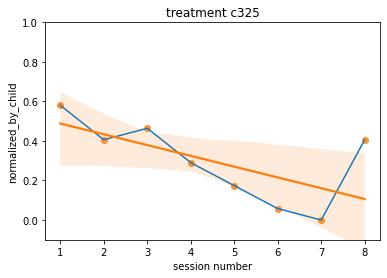

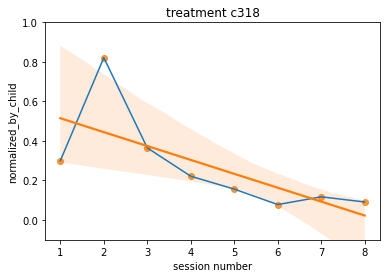

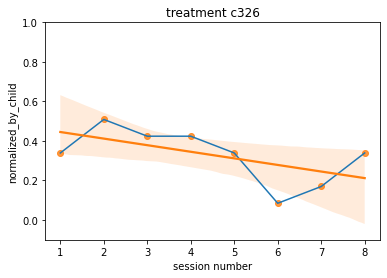

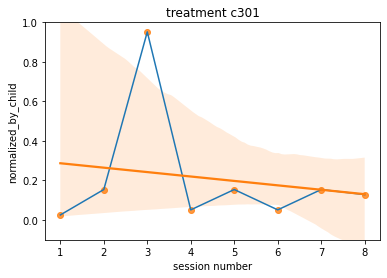

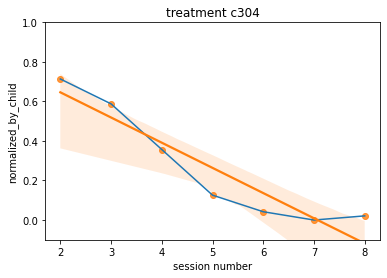

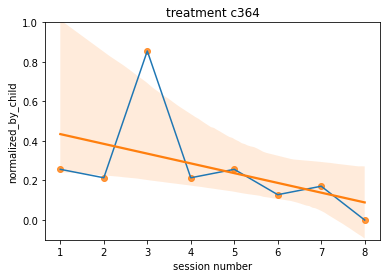

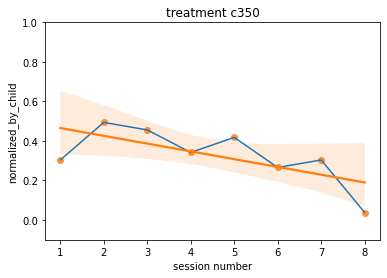

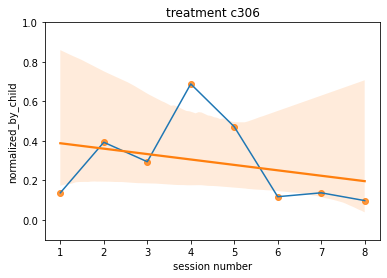

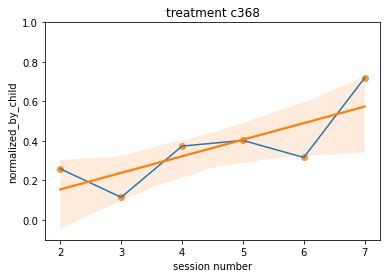

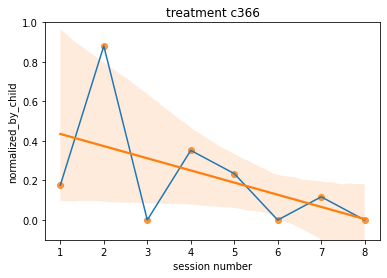

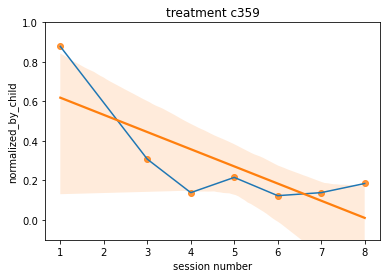

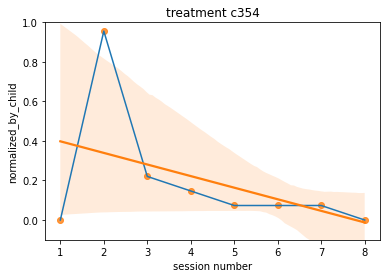

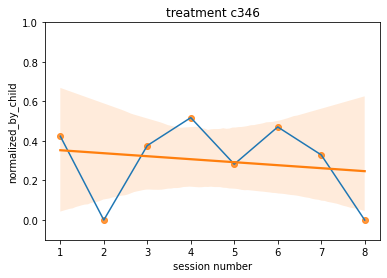

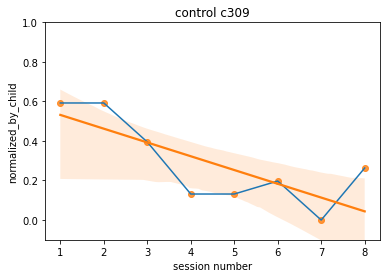

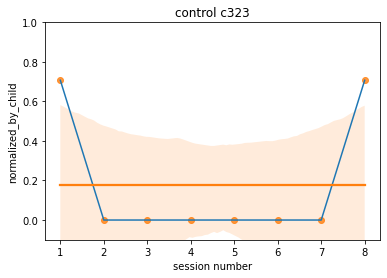

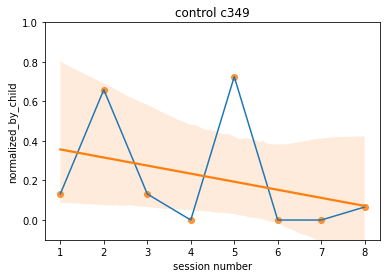

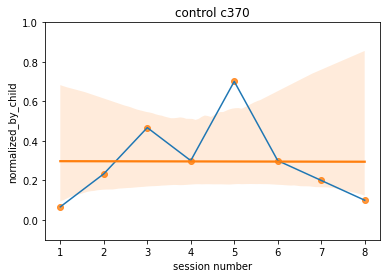

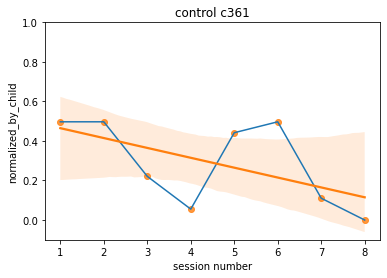

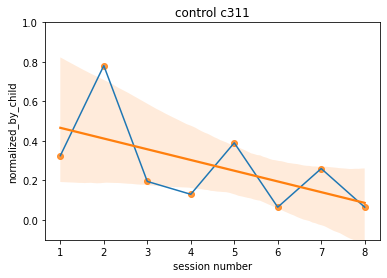

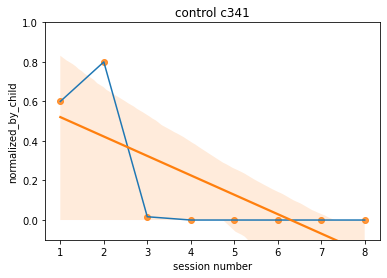

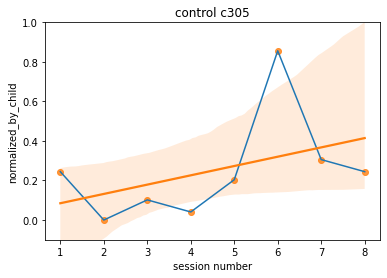

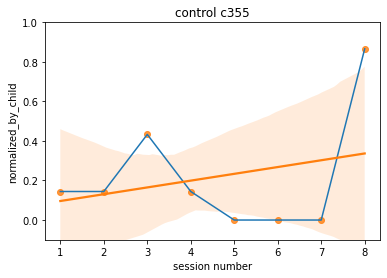

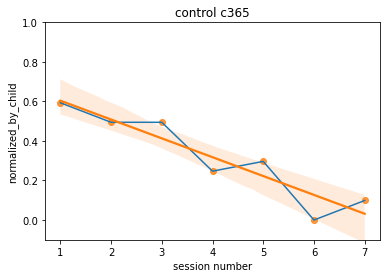

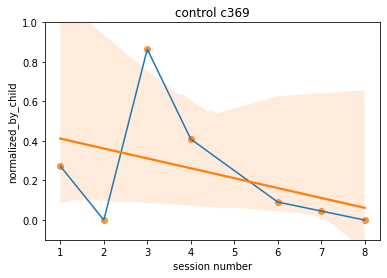

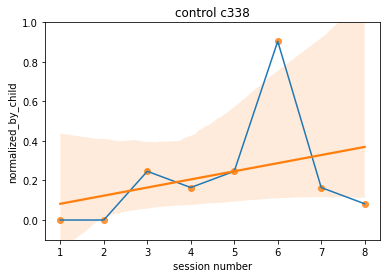

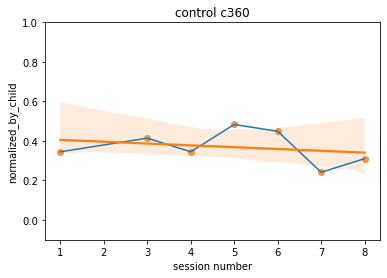

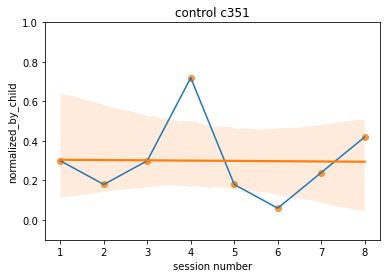

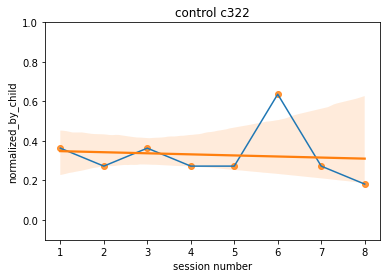

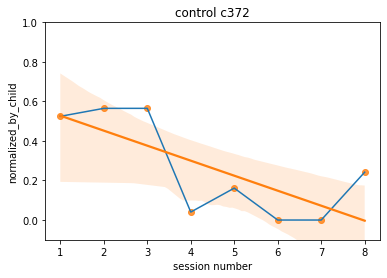

In [301]:
plotting_value = 'total_avg'
plotting_value = 'total_sum'
# plotting_value = 'decoding_sum'
# plotting_value = 'explanation_sum'
# plotting_value = 'decoding_explanation_sum'
# feature_selection = 'original_vals'
feature_selection = 'normalized_by_child'

normalized_df = get_normalized_dataframe(data, plotting_value)
print(normalized_df.head(5))
# 1. Plot box plots
for group_condition in ['treatment', 'control']:
    group_child_data = []
    normalized_group_data = normalized_df[normalized_df['group'] == group_condition]
    for child in list(set(normalized_group_data['child_id'].values)):
        # if child in ['c304']:
        #     continue
        # Get Child's sessions
        child_data = normalized_group_data[normalized_group_data['child_id'] == child]
        child_data = child_data[child_data['session number'].between(1, 8)]
        if len(child_data) < 6:
            continue
        child_data.sort_values('session number')
        plt.plot(child_data['session number'], child_data[feature_selection])
        ax = sns.regplot(x="session number", y=feature_selection, data=child_data).set(title=group_condition + " " + child)
        plt.ylim(-0.1, 1)
        plt.show(block=True)

    # print(group_child_data)
    # child_array = np.array(group_child_data)
    # # plt_data = np.transpose(child_array)
    # plt_data = child_array
    # print(plt_data)
    # fig = plt.figure(figsize=(15, 10))
    # ax = fig.add_axes([0, 0, 1, 1])
    # boxplt = ax.boxplot(plt_data)
    # plt.show()

### Part 3. Pre-Intervention Session with First Two Intervention Sessions

In [284]:
feature_selection = 'original_vals'
# 2. Calculate Pre&Post data differences
def get_data_by_condition_and_sessions(condition, session_num):
    extracted_df = normalized_df[(normalized_df['group'] == condition)  & (normalized_df['session number'] == session_num)]
    extracted_df.sort_values('child_id')
    extracted = extracted_df[feature_selection].values
    return extracted

def get_statistic_differences_result(data_list):
    normalities = [single_variable_normality_test(_list) for _list in data_list]
    non_parametric = True
    if False in normalities:
        non_parametric = True
        print("Non-parametric data, using non-parametric test...")
    
    if non_parametric:
        v, p, rst = kw_test(data_list)
    else:
        v, p, rst = anova_test(data_list)
    
    if rst:
        print("Significant difference exists!!! Post-hoc analysis...")
        _, _, _, direction = post_hoc_mannwhiteu_test(*data_list)
        print("Identified a trend -> " + direction)
    else:
        print("No significant difference found.")
    

# a. Between-Group Comparison within the same sessions
print("\nBetween Group Comparison:")
print("\nPre Session Comparison")
pre_control = get_data_by_condition_and_sessions('control', 1)
pre_treatment = get_data_by_condition_and_sessions('treatment', 1)
get_statistic_differences_result([pre_control, pre_treatment])

print("\nPost Session Comparison")
post_control = get_data_by_condition_and_sessions('control', 8)
post_treatment = get_data_by_condition_and_sessions('treatment', 8)
get_statistic_differences_result([post_control, post_treatment])


print("\nIntervention Sessions Comparison")
for session in range(1, 9):
    print("\nBetween Group - Session ", session)
    control = get_data_by_condition_and_sessions('control', session)
    treatment = get_data_by_condition_and_sessions('treatment', session)
    get_statistic_differences_result([control, treatment])


Between Group Comparison:

Pre Session Comparison
Non-parametric data, using non-parametric test...
No significant difference found.

Post Session Comparison
No significant difference found.

Intervention Sessions Comparison

Between Group - Session  1
Non-parametric data, using non-parametric test...
No significant difference found.

Between Group - Session  2
Non-parametric data, using non-parametric test...
No significant difference found.

Between Group - Session  3
Significant difference exists!!! Post-hoc analysis...
Identified a trend -> smaller

Between Group - Session  4
Non-parametric data, using non-parametric test...
Significant difference exists!!! Post-hoc analysis...
Identified a trend -> smaller

Between Group - Session  5
Non-parametric data, using non-parametric test...
No significant difference found.

Between Group - Session  6
Non-parametric data, using non-parametric test...
No significant difference found.

Between Group - Session  7
Non-parametric data, using n

/Users/xiajie/miniconda3/envs/storybook-script/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/xiajie/miniconda3/envs/storybook-script/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/xiajie/miniconda3/envs/storybook-script/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/xiajie/miniconda3/envs/storybook-script/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/xiajie/mi

In [286]:
# b. Within-Group Comparison within sessions 1 vs 2, 3, 4; 1 vs 8, 2 vs 3, 4
print("\nWithin Group Comparison:")

print("\nPre Session with Intervention Sessions")
anchor_session = 1
for session in range(2, 9):
    print("\n")
    for condition in ['control', 'treatment']:
        print("In %s, Pre-Session Vs Session %d"%(condition, session))
        data_1 = get_data_by_condition_and_sessions(condition, anchor_session)
        data_2 = get_data_by_condition_and_sessions(condition, session)
        print(data_1)
        print(data_2)
        get_statistic_differences_result([data_1, data_2])

print("\nIntervention Initial Session with Intervention Sessions")
anchor_session = 2
for session in range(3, 9):
    print("\n")
    for condition in ['control', 'treatment']:
        print("In %s, Pre-Session Vs Session %d"%(condition, session))
        data_1 = get_data_by_condition_and_sessions(condition, anchor_session)
        data_2 = get_data_by_condition_and_sessions(condition, session)
        print(data_1)
        print(data_2)
        get_statistic_differences_result([data_1, data_2])


Within Group Comparison:

Pre Session with Intervention Sessions


In control, Pre-Session Vs Session 2
[12  9  5  4  1  0 36  2  5  1 10  9 12  6  2 13]
[ 0  9 12  3  0  0 48 10  3  1  9 10  0  7 14]
Non-parametric data, using non-parametric test...
No significant difference found.
In treatment, Pre-Session Vs Session 2
[ 1  7 23 10  4  9  8  0 57  6  3]
[ 6 34 20 63  7  6  0 13 13  5 15  9]
Non-parametric data, using non-parametric test...
No significant difference found.


In control, Pre-Session Vs Session 3
[12  9  5  4  1  0 36  2  5  1 10  9 12  6  2 13]
[ 5  6  3  4  0  3  1  2  5  3 12  4 10 19 14 14]
Non-parametric data, using non-parametric test...
No significant difference found.
In treatment, Pre-Session Vs Session 3
[ 1  7 23 10  4  9  8  0 57  6  3]
[37 28 15 28  8  5  8 12  3 20 20  0  4]
Non-parametric data, using non-parametric test...
No significant difference found.


In control, Pre-Session Vs Session 4
[12  9  5  4  1  0 36  2  5  1 10  9 12  6  2 13]
[ 2  2  2  

### Part 4. Exploration Correlation with Children's Prior Exploration

In [303]:
# Correlation test between evolution and pre-test
target_value = 'total_sum'
feature_selection = "normalized_by_child"
feature_selection = 'original_vals'
for condition in ['control', 'treatment']:
    print("\nCondition: ", condition)
    # Get children who has both pre and post
    pre_session = []
    post_session = []
    condition_df = normalized_df[(normalized_df['group'] == condition)]
    for child in list(set(condition_df['child_id'].values)):
        child_pre = condition_df[(condition_df['child_id'] == child) & (condition_df['session number'] == 1)]
        child_post = condition_df[(condition_df['child_id'] == child) & (condition_df['session number'] == 8)]
        # normalized_df[(normalized_df['group'] == condition)  & (normalized_df['session number'] == session_num)]
        if len(child_pre) == 0 or len(child_post) == 0:
            continue
        else:
            pre_session.append(child_pre[feature_selection].values[0])
            post_session.append(child_post[feature_selection].values[0])

    evolution = [post_session[i] - pre_session[i] for i in range(len(pre_session))] 
    # print(pre_session)
    # print(evolution)
    corr, p = stats.spearmanr(pre_session, evolution)
    if p < 0.05:
        print('Null rejected with p at %f, data related with correlation %f'%(p, corr))
    else:
        print('Data Unrelated. %f'%(p))


Condition:  control
Null rejected with p at 0.004342, data related with correlation -0.690926

Condition:  treatment
Null rejected with p at 0.001065, data related with correlation -0.844758



### Part 5. Exploration Correlation with Children's Prior Knowledge

In [291]:
# Correlation test between evolution and pre-test
# target_value = 'decoding_explanation_sum'
target_value = 'total_sum'
# target_value = 'total_avg'
# target_value = 'word_tap_sum'
# target_value = 'sceneobj_tap_sum'
# target_value = 'audio_play_sum'
# target_value = 'decoding_sum'
# target_value = 'explanation_sum'
feature_selection = 'normalized_by_child'
for condition in ['control', 'treatment']:
    print("\nCondition: ", condition)
    # Get children who has both pre and post
    group_data = data[data['group'] == condition]
    # Remove the rows that doesnt have pre-test
    filtered_data = group_data[group_data['pre_assessment_rate'] > 0]

    # Session-Wise
    # for session in range(1, 9):
    #     print("For Session", session)
    #     session_data = filtered_data[filtered_data['session number'] == session]
    #     prior_knowledge = list(session_data['pre_assessment_rate'].values)
    #     exploration = list(session_data[target_value].values)
    #     corr, p = stats.spearmanr(exploration, prior_knowledge)
    #     if p < 0.05:
    #         print('Null rejected with p at %f, data related with correlation %f'%(p, corr))
    #     else:
    #         print('Data Unrelated. %f'%(p))

    for child in list(set(filtered_data['child_id'].values)):
        print("For Child", child)
        child_data = filtered_data[filtered_data['child_id'] == child]
        prior_knowledge = list(child_data['pre_assessment_rate'].values)
        exploration = list(child_data[target_value].values)
        corr, p = stats.spearmanr(exploration, prior_knowledge)
        if p < 0.05:
            print('Null rejected with p at %f, data related with correlation %f'%(p, corr))
        else:
            print('Data Unrelated. %f'%(p))
            print(exploration)
            print(prior_knowledge)
            print("\n")

    # prior_knowledge = list(filtered_data['pre_assessment_rate'].values)
    # exploration = list(filtered_data[target_value].values)
    # corr, p = stats.spearmanr(exploration, prior_knowledge)
    # if p < 0.05:
    #     print('Null rejected with p at %f, data related with correlation %f'%(p, corr))
    # else:
    #     print('Data Unrelated. %f'%(p))


Condition:  control
For Child c309
Data Unrelated. 0.105005
[9, 9, 6, 2, 2, 3, 0, 4]
[0.142857143, 0.84375, 0.586206897, 0.846153846, 0.736842105, 0.866666667, 1.0, 0.958333333]


For Child c323
Data Unrelated. 0.202884
[1, 0, 0, 0, 0, 0, 0, 1]
[0.625, 0.571428571, 0.517241379, 0.615384615, 0.578947368, 0.533333333, 0.692307692, 0.666666667]


For Child c349
Data Unrelated. 0.478726
[2, 10, 2, 0, 11, 0, 0, 1]
[0.71875, 0.738095238, 0.655172414, 0.730769231, 0.736842105, 0.866666667, 0.923076923, 0.708333333]


For Child c351
Data Unrelated. 0.327582
[5, 3, 5, 3, 1, 4, 7]
[0.8125, 0.952380952, 0.551724138, 0.5, 0.533333333, 0.538461538, 0.625]


For Child c361
Data Unrelated. 0.818177
[9, 9, 4, 1, 8, 9, 2, 0]
[0.78125, 0.833333333, 0.75862069, 0.730769231, 0.736842105, 0.8, 0.846153846, 0.958333333]


For Child c311
Data Unrelated. 0.955106
[5, 12, 3, 2, 6, 1, 4, 1]
[0.875, 0.880952381, 0.724137931, 0.923076923, 0.894736842, 0.933333333, 1.0, 0.375]


For Child c341
Data Unrelated. 0.0